<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Filtering and Detrending with Pyleoclim

Alexander James Department of Earth Sciences, University of Southern California

Author = {"name": "Alexander James", "affiliation": "Department of Earth Sciences, University of Southern California", "email": "akjames@usc.edu", "orcid": "0000-0001-8561-3188"}

## Preamble

### Goals:

* Become familiar with the various filtering methods and some of their arguments
* Become familiar with the various detrending methods and some of their arguments

**Reading Time:**

10 minutes

### Keywords

Signal Processing; Visualization

### Pre-requisites

None. This tutorial assumes basic knowledge of Python. If you are not familiar with this coding language, check out this tutorial: http://linked.earth/ec_workshops_py/.

### Relevant Packages

Pandas; Matplotlib

## Data Description

Benthic foraminifera $\delta^{18}O$ data from the [LR04 benthic stack](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2004PA001071) stored as `LR04.csv` in the data folder.

## Demonstration

Let's import the packages needed for this tutorial:

In [1]:
import pyleoclim as pyleo
import pandas as pd

### Step 1: Load a Series object from a csv file

To do so, we will first read the data from a csv file and load into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html):

In [2]:
df = pd.read_csv('../data/LR04.csv',skiprows=4)
df.head()

,Time (ka),Benthic d18O (per mil),Standard error (per mil)
0,0.0,3.23,0.03
1,1.0,3.23,0.04
2,2.0,3.18,0.03
3,3.0,3.29,0.03
4,4.0,3.30,0.03


We can then load that dataframe into a `Pyleoclim.Series` object and visualize. For more information on loading data from a csv file into a `Series`, see the `loading_to_series.ipynb` tutorial.

In [3]:
ts_d18O = pyleo.Series(time =  df['Time (ka)'], value = df['Benthic d18O (per mil)  '],
                  time_name = 'Age', value_name = r'$\delta^{18}O$',
                  time_unit = 'BP ka', value_unit = '$\perthousand$').standardize()       

Time axis values sorted in ascending order


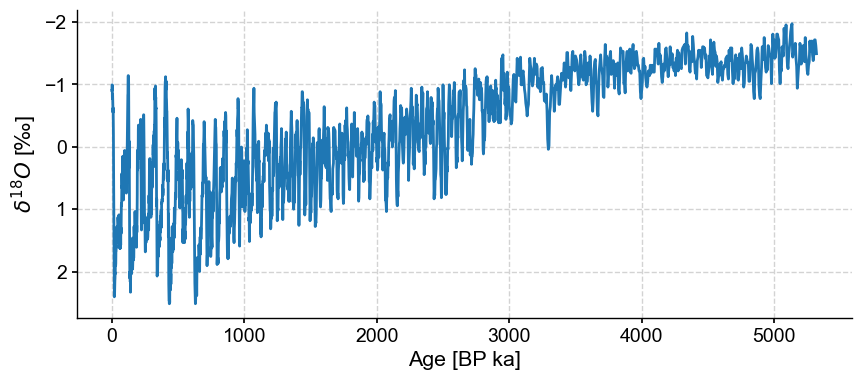

In [4]:
fig, ax = ts_d18O.plot()
ax.invert_yaxis()

### Step 2: Detrending

To detrend the data using `Pyleoclim` we simply call the `.detrend()` method on a `Series` object. There are several detrending methods which are covered more thoroughly by the [documentation](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.detrend).

In this case, we'll use the EMD (Empirical Mode Decomposition) method. This decomposes the series into different modes and removes the last one on the assumption that it describes the trend in the series.

In [5]:
ts_emd = ts_d18O.detrend(method='emd')

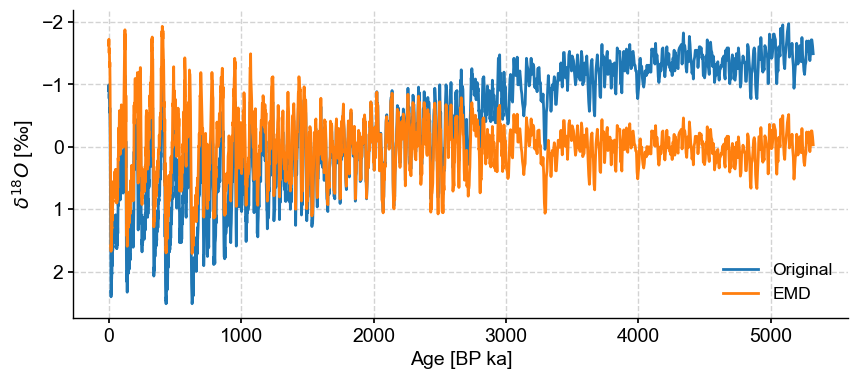

In [6]:
fig, ax = ts_d18O.plot(label='Original')
ts_emd.plot(label='EMD',ax=ax)
ax.invert_yaxis()

We can also pass method-dependent keyword arguments for each of the different methods. For example, with EMD, if we specify a value for the keyword `n`, it will remove the n smoothest modes rather than the single smoothest mode (by default, `n`=1).

In [9]:
ts_emd_n = ts_d18O.detrend(n=3)

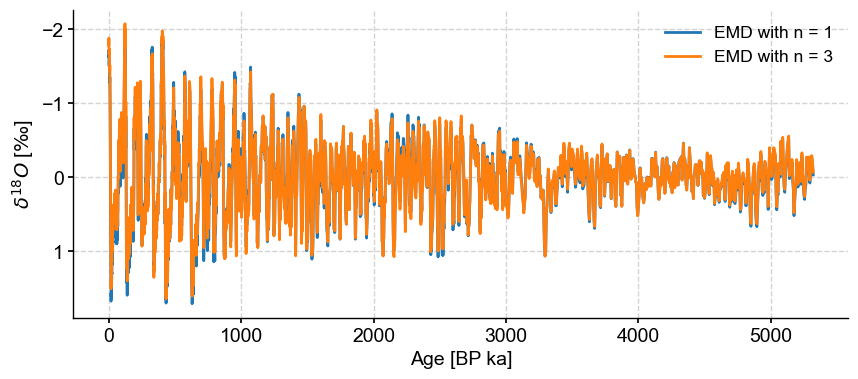

In [10]:
fig, ax = ts_emd.plot(label='EMD with n = 1')
ts_emd_n.plot(label='EMD with n = 3',ax=ax)
ax.invert_yaxis()

As you can see, this isn't really necessary for this record, but it does come in handy on occasion, and other methods can be more sensitive to parameter values, so it's good to be aware that some configurability exists. Note that these keyword arguments are **method dependent**, meaning that you'll need to consult the [documentation](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#pyleoclim.core.series.Series.detrend) for each in order to make sure you know which keyword arguments can be used with each method.

There are other methods available to us such as `linear`, `savitzky-golay`, and `constant`. Exploring these (and each of their parameters) is left as an exercise for the reader.

### Step 3: Filtering

To filter the data using `Pyleoclim` we simply call the `.filter()` method on a `Series` object. There are several filtering methods which are covered more thoroughly in the [documentation](https://pyleoclim-util.readthedocs.io/en/master/core/api.html?highlight=lipd#pyleoclim.core.series.Series.filter).

Here we'll use the lanczos filter with a `cutoff_scale` of 80 to remove all frequencies with a period of less than 80ka (we pass the number 80 because our time axis is already in units of ka). In this case we are low-pass filtering the data. We have to interpolate the series because the lanczos method expects an evenly-spaced series. See the [data imputation tutorial]() for more information on interpolation and other methods of creating evenly-spaced time series.

In [11]:
ts_low = ts_d18O.interp().filter(method='lanczos',cutoff_scale=80)

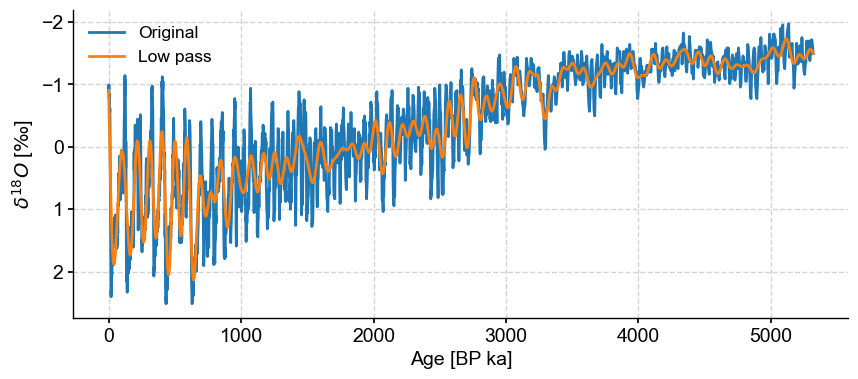

In [12]:
fig, ax = ts_d18O.plot(label='Original')
ts_low.plot(label='Low pass',ax=ax)
ax.invert_yaxis()

Note: One could also pass a cutoff frequency, though we find the cutoff scale more user-friendly.

If we look at the results of performing wavelet analysis on our series before and after filtering, we can clearly see the effect of our low pass filter. You can learn more about spectral analysis in Pyleoclim in the [spectral analysis tutorial]().

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


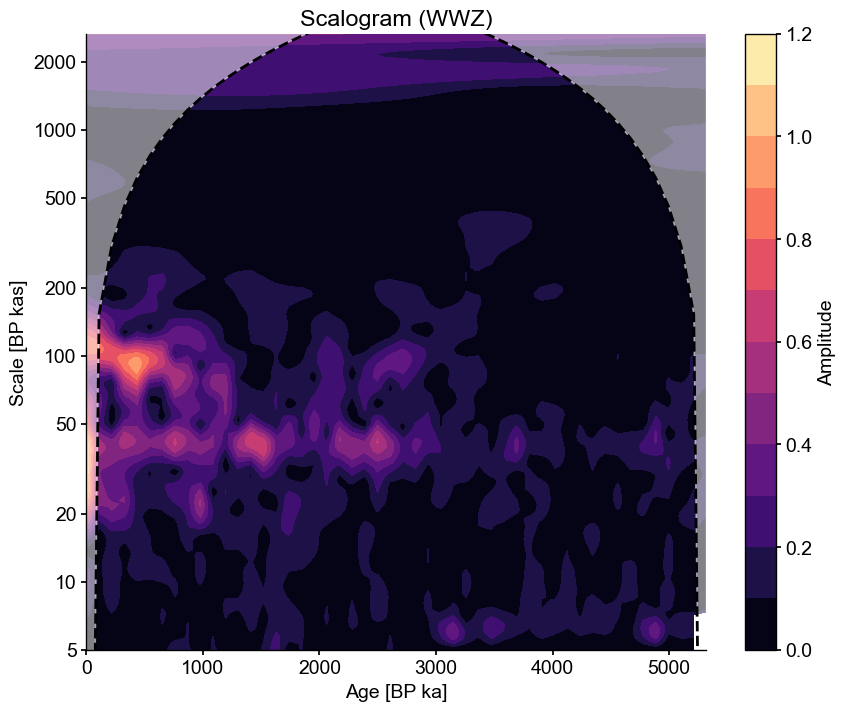

In [11]:
fig, ax = ts_d18O.wavelet(method='wwz').plot()

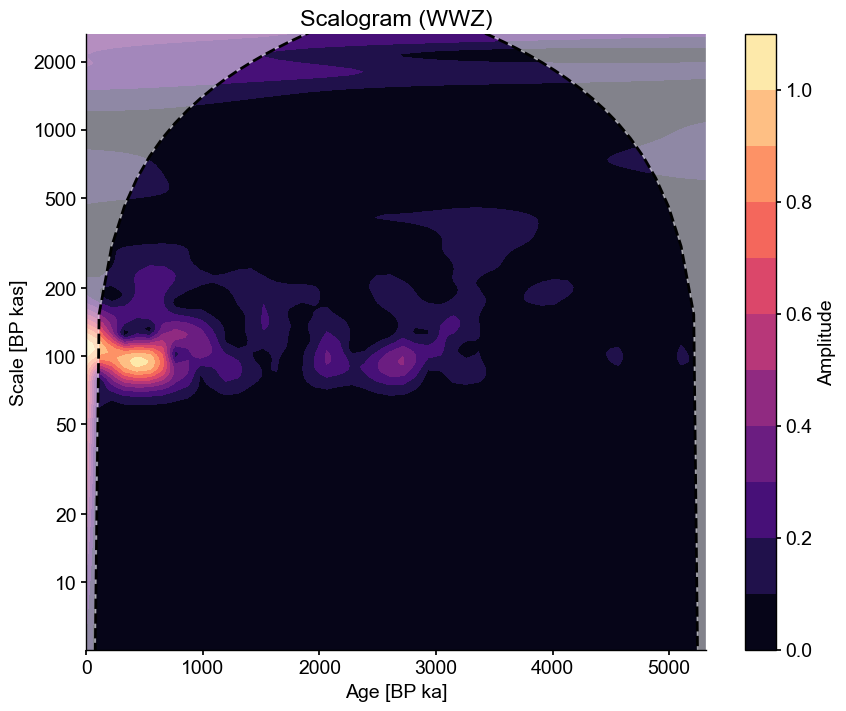

In [12]:
fig, ax = ts_low.wavelet(method='wwz').plot()

If we want to apply a band pass filter, we can pass a list of values to our `cutoff_scale` argument.

In [13]:
ts_band = ts_d18O.interp().filter(method='butterworth',cutoff_scale=[10,80])

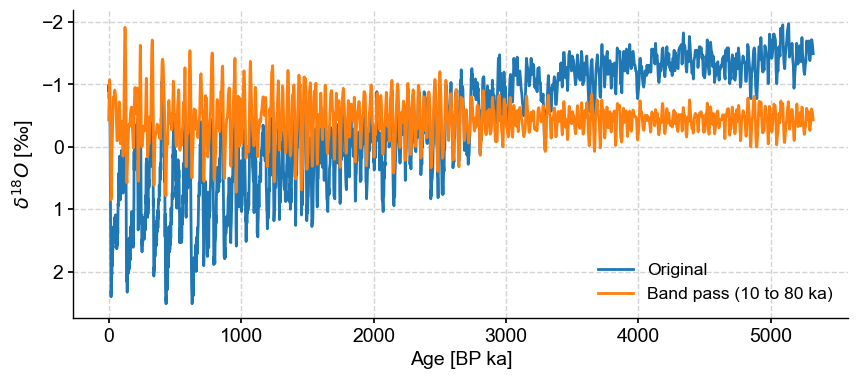

In [14]:
fig, ax = ts_d18O.plot(label='Original')
ts_band.plot(label='Band pass (10 to 80 ka)',ax=ax)
ax.invert_yaxis()

Checking our work by running wavelet analysis (done below) shows that we've isolated the components of the series whose periodicities lie between 10 and 80ka.

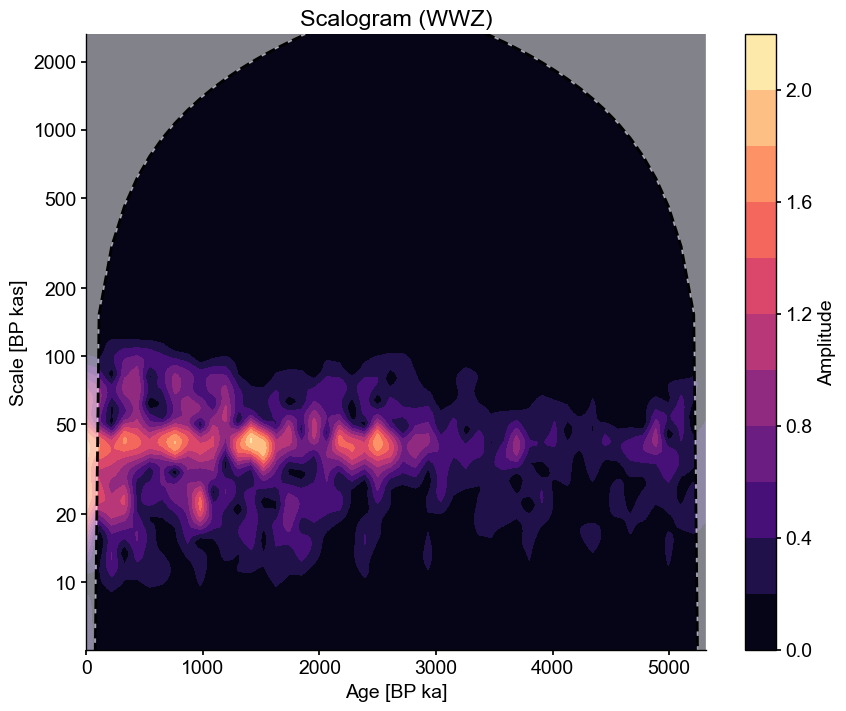

In [15]:
fig, ax = ts_band.wavelet(method='wwz').plot()

To apply a high pass filter, we simply apply a low pass filter and then subtract the values of the low pass filter series from our original series.

In [23]:
#Applying a high pass filter with a cutoff_scale of 50

ts_high = ts_d18O.copy()
ts_high.value -= ts_d18O.interp().filter(method='lanczos',cutoff_scale=50).value

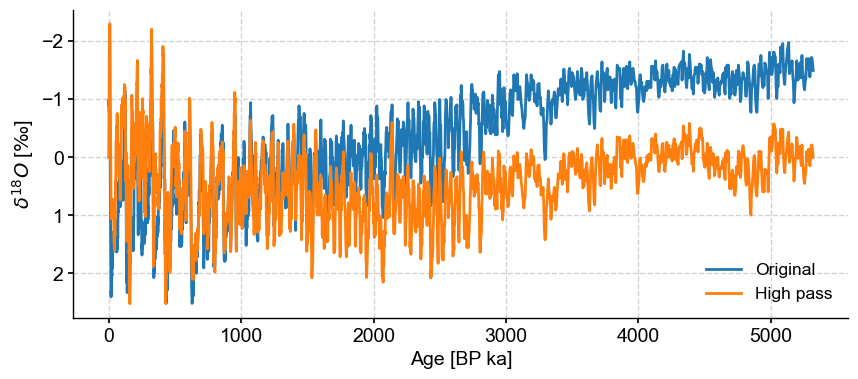

In [17]:
fig, ax = ts_d18O.plot(label='Original')
ts_high.plot(label='High pass',ax=ax)
ax.invert_yaxis()

Though removal of the long term trend in our series is an obvious consequence of our high pass filter, wavelet analysis should show us how the frequency profile of this series has changed.

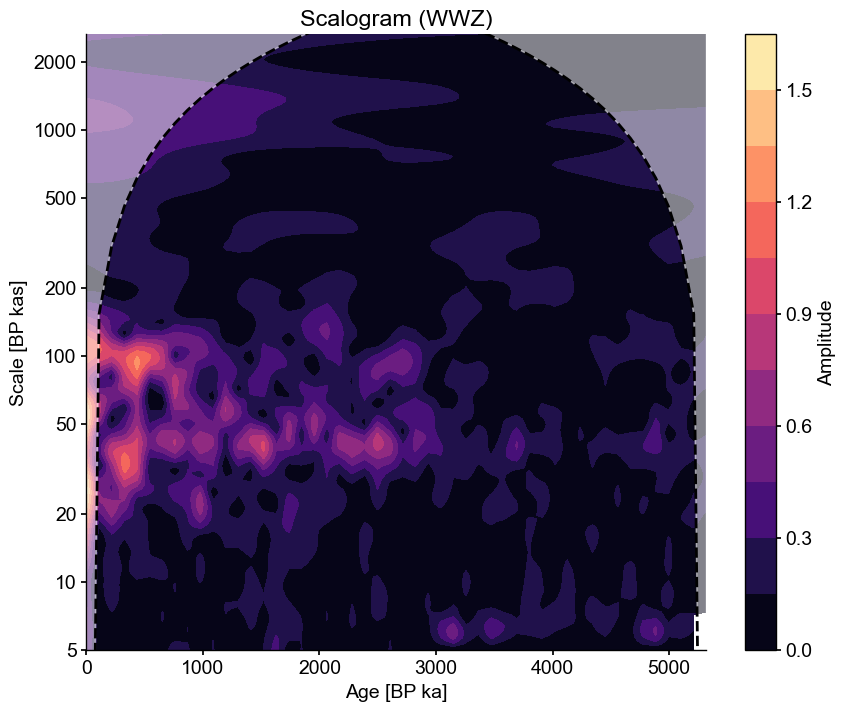

In [18]:
fig, ax = ts_high.wavelet(method='wwz').plot()

It's not perfect, but the power of the components of the series with longer periodicities has decreased.

As with `.detrend()`, `.filter()` accepts method specific key word arguments. For example, in the case of the savitzky-golay method, we can pass `window_length` to adjust the size of the filter window. 

In [19]:
ts_sg_low = ts_d18O.interp().filter(method='savitzky-golay',cutoff_scale=80)
ts_sg_win = ts_d18O.interp().filter(method='savitzky-golay',cutoff_scale=80,window_length=81)

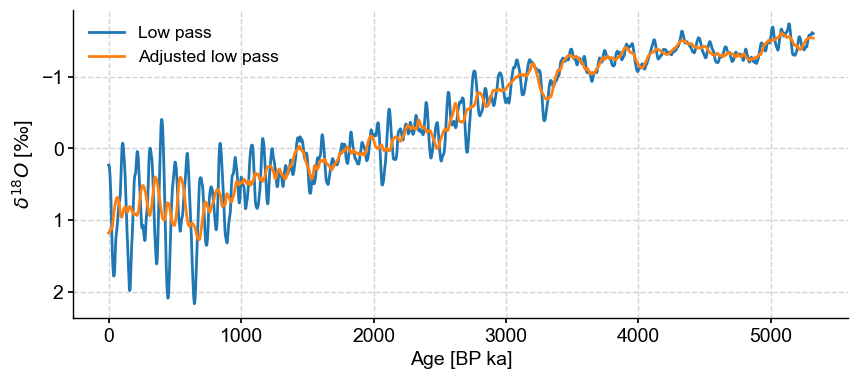

In [20]:
fig, ax = ts_sg_low.plot(label='Low pass')
ts_sg_win.plot(label='Adjusted low pass',ax=ax)
ax.invert_yaxis()

Again there are a number of other methods we could use here including: `butterworth`, `lanczos`, and `firwin`. Each has its own keyword arguments. Exploring these (and their [documentation](https://pyleoclim-util.readthedocs.io/en/master/core/api.html?highlight=lipd#pyleoclim.core.series.Series.filter)), is left as an exercise for the reader.